# **DisQCO**: Distributed Quantum Circuit Optimisation

## Circuit partitioning basics

This notebook introduces the new structure of DisQCO, a software tool for distributing quantum circuits across networks of quantum computers.

Distributing quantum circuits across quantum networks requires circuits to be *partitioned*. A partitioned quantum circuit is a set of sub-circuits which interact only via entanglement and LOCC, allowing all cross-QPU interaction to be handled by the network. The quality of a partitioned quantum circuit is determined by the amount of entanglement required. *Good* partitioning requires minimal use of entanglement. There are various formulations for quantum circuit partitioning, DisQCO is based on a generalised graphical framework, which uses hypergraphs with both spatial and temporal extension, allowing us to model logical qubit connectivity and time-evolution in quantum circuits. Partitioning problems are typically NP-hard, so DisQCO employs tailored *multilevel partitioning*, powered by well-established heuristics, to achieve low cost partitioning of circuits.

This notebook walks through the basics elements of DisQCO, circuits, temporal hypergraphs, networks and coarseners.


The first key element of DisQCO is the *temporal hypergraph*, which models quantum operations over time and *teleportation compatibility* of quantum operations. Temporal hypergraphs are instantiated by the ```QuantumCircuitHyperGraph```, which is built from a ```qiskit.QuantumCircuit``` object. We first create a quantum circuit to demonstrate the creation of a ```QuantumCircuitHyperGraph```.

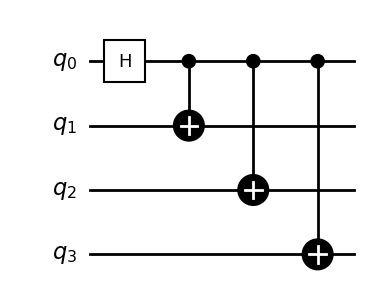

In [276]:
# Import relevant libraries

from qiskit import QuantumCircuit

# Define an example quantum circuit

num_qubits = 4

circuit = QuantumCircuit(num_qubits)

circuit.h(0)  # Apply Hadamard gate to each qubit

for i in range(num_qubits - 1):
    circuit.cx(0, i + 1)  # Entangle qubit 0 with all others

circuit.draw(output='mpl', style='bw')

This basic circuit creates a GHZ state across all qubits, provided they are initialised to the $\ket{0}$ state. In ```disqco```, we work in a generalised gate set, which uses parameterised single-qubit and two-qubit gates to compress the circuit representation. The gate set consists of the $U(\theta, \phi, \lambda)$ single-qubit rotation gate, and the $CP(\theta)$ two-qubit controlled-phase gate. This allows us to compress many single-qubit gates together, and easily determine the compatibility for gate teleportation. We can use the ```qiskit.transpile``` method to convert the circuit to this gate set.

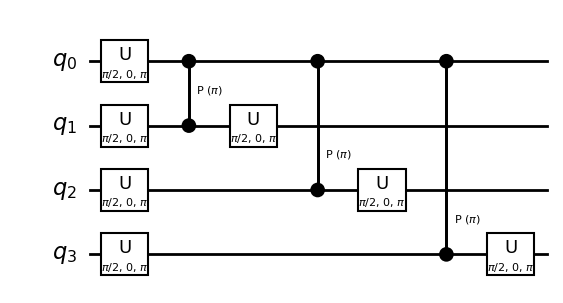

In [277]:
from qiskit import transpile


circuit = transpile(circuit, basis_gates=['u', 'cp'])

# Display the transpiled circuit
circuit.draw(output='mpl', style='bw')

We can build the hypergraph in two stages, first using a basic graphical quantum circuit, then by accounting for gate teleportation compatibility. By default, when creating a ```QuantumCircuitHyperGraph``` we will automatically group gates into hyper-edges by teleportation compatibility. For demonstration, we will first create a graph without any grouped hyperedges.

The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz
depth: 5


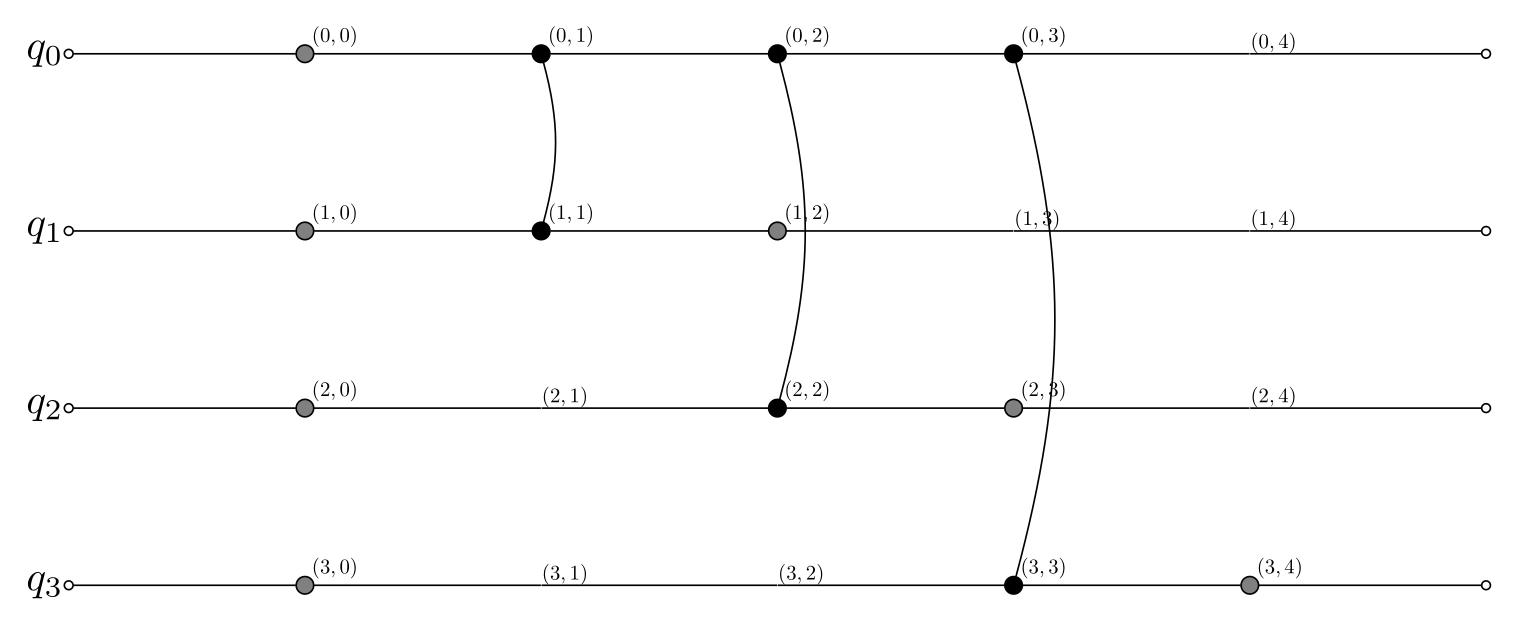

In [278]:
from disqco.graphs.QC_hypergraph import QuantumCircuitHyperGraph

# Create a hypergraph from the quantum circuit
hypergraph_basic = QuantumCircuitHyperGraph(circuit, group_gates=False)

# Display the hypergraph

%load_ext jupyter_tikz
hypergraph_basic.draw(dpi=300)


This basic graph indexes all nodes by a tuple $(q,t)$, corresponding to the qubit and time-step of the circuit. Edges exist between all $(q,t)$ and $(q, t+1)$, representing time-continuity of qubits. Edges also connect qubits involved in controlled-phase gates.

When we have chains of contiguous $CP(\theta)$ gates with a common control qubit, they are considered *gate teleportation compatible*, meaning they can be teleported using a single shared e-bit. If we set the flag ```group_gates=True```, then we include a sub-routine for grouping such gates together into hyper-edges, which will allow us to account for the true entanglement cost of gate teleportation.

The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz
depth: 5


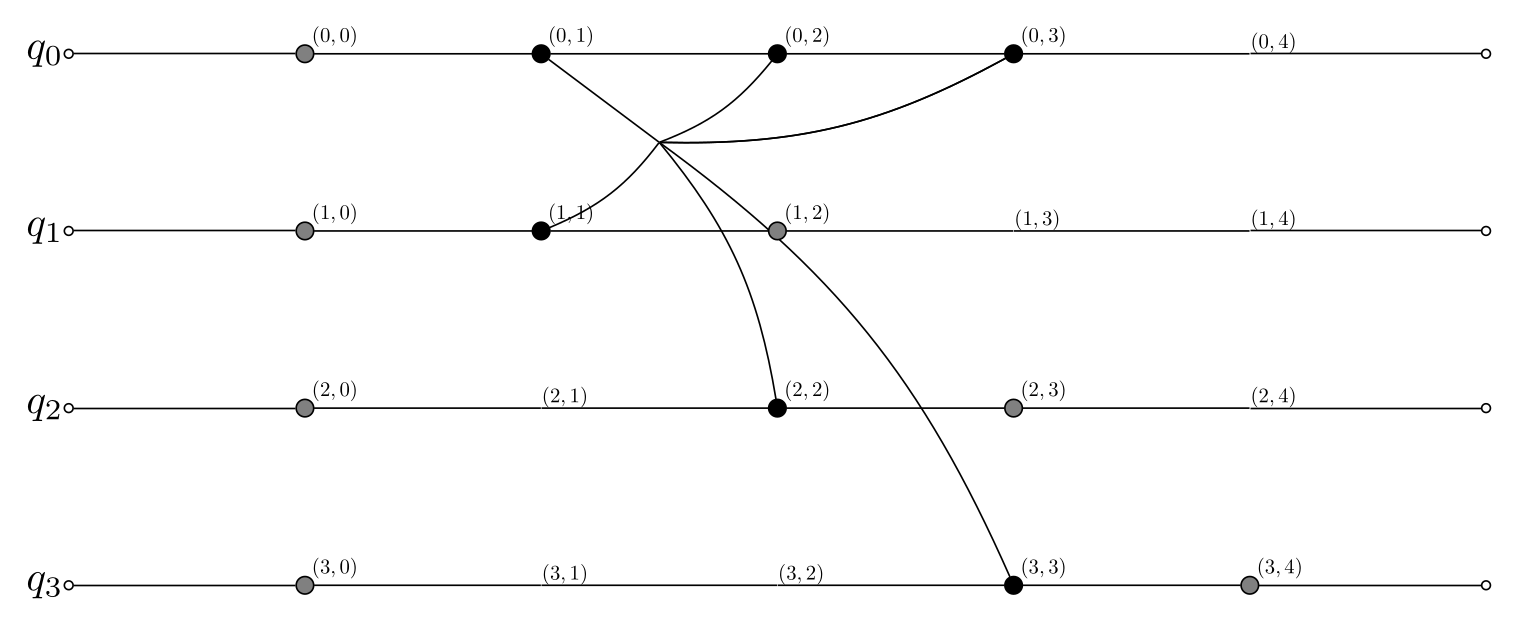

In [279]:
# Create a hypergraph from the quantum circuit
hypergraph = QuantumCircuitHyperGraph(circuit, group_gates=True)

# Display the hypergraph

%load_ext jupyter_tikz
hypergraph.draw(dpi=300)


In order to partition any quantum circuit, we need to know what computational resources we have available. For this, we use the ```QuantumNetwork``` class. A quantum network is defined by a network topology, and a list of data qubit register sizes. At this level, we are not interested in the internal qubit connectivity, we will leave this to later compilation. If the connectivity is not specified, the network will be created with all-to-all connectivity. The user can specify their own couplings, or choose from some presets such as ```linear_coupling``` or ```grid_coupling```.

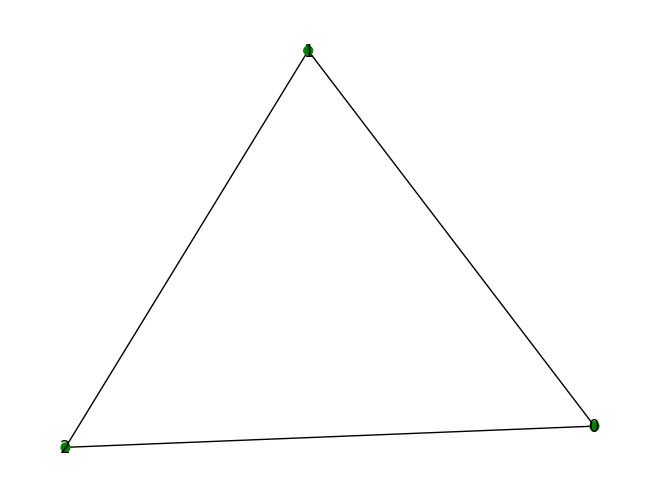

In [280]:
from disqco.graphs.quantum_network import QuantumNetwork, linear_coupling, grid_coupling, all_to_all

# First define the QPU sizes

qpu_sizes = {0 : 2, 1 : 2, 2 : 2} # Three QPUs with 2 qubits each. Structure is {QPU ID : number of data qubits}

num_qpus = len(qpu_sizes)

# Create a quantum network with all-to-all coupling
coupling = all_to_all(num_qpus)

network = QuantumNetwork(qpu_sizes, qpu_connectivity=coupling)

# QuantumNetwork.draw() uses the mpl backend via NetworkX, so we can display it directly.
network.draw()


In order to map a graph onto the network, we use a ```partition_assignment```, which assigns each node of the ```QuantumCircuitHyperGraph``` to a QPU in the network. We denote this assignment by $\Phi$, and use a numpy array for fast indexing. The element $\Phi_{i,j}$ denotes the QPU to which qubit $j$ is assigned at time $i$. We can start by creating an initial assignment function which we will aim to optimise.

In [281]:
from disqco.parti.FM.FM_methods import set_initial_partition_assignment

partition_assignment = set_initial_partition_assignment(hypergraph, network)

print(f'Partition assignment: \n {partition_assignment}')

Partition assignment: 
 [[0 0 1 1]
 [0 0 1 1]
 [0 0 1 1]
 [0 0 1 1]
 [0 0 1 1]]


We can use the ```partition_assignment``` to draw the hypergraph mapped onto the network.

depth: 5


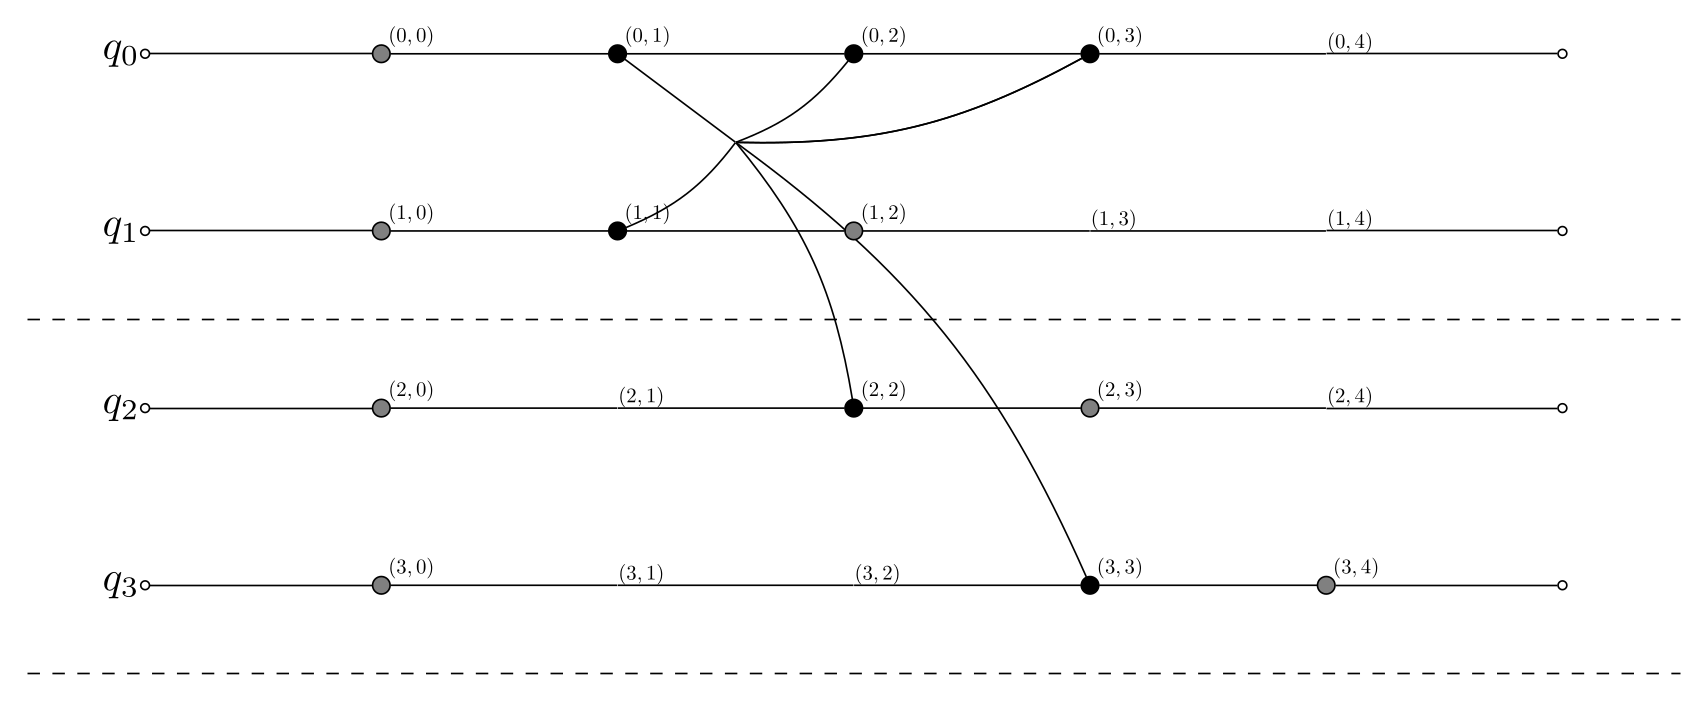

In [282]:
hypergraph.draw(network=network, assignment=partition_assignment, show_labels=True, dpi=300)

This initial ```partition_assignment``` is sufficient to extract a distributed circuit, albeit not one which has been optimised. Let us first extract two example circuits, one from each version of the graph to visualise the outputs.

In [283]:
from disqco.circuit_extraction.circuit_extractor import PartitionedCircuitExtractor

circuit_extractor = PartitionedCircuitExtractor(hypergraph_basic, network, partition_assignment=partition_assignment)

partitioned_circuit = circuit_extractor.extract_partitioned_circuit()

Number of e-bits requested: 2


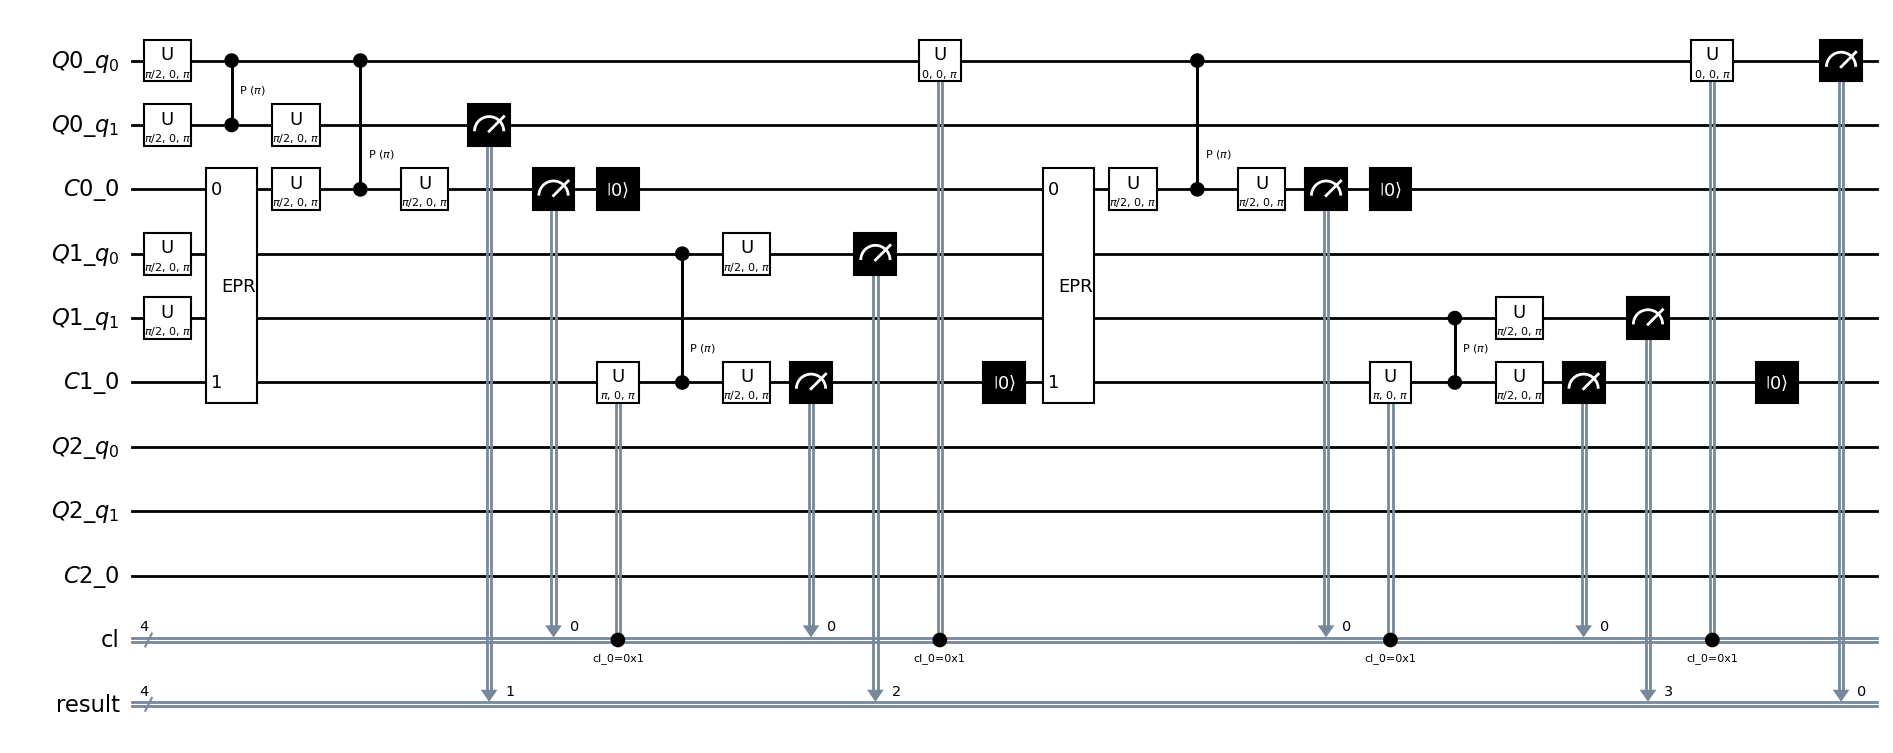

In [284]:
print(f'Number of e-bits requested: {partitioned_circuit.count_ops()["EPR"]}')

partitioned_circuit.draw(output='mpl', style='bw', fold=50)

If we use the basic graph, an e-bit, or EPR pair is requested for each inter-QPU gate, which leads to a total of 2 e-bits. Even with no optimisation, we will achieve a lower e-bit count using the hypergraph which has merged edges into hyperedges.



Number of e-bits requested: 1


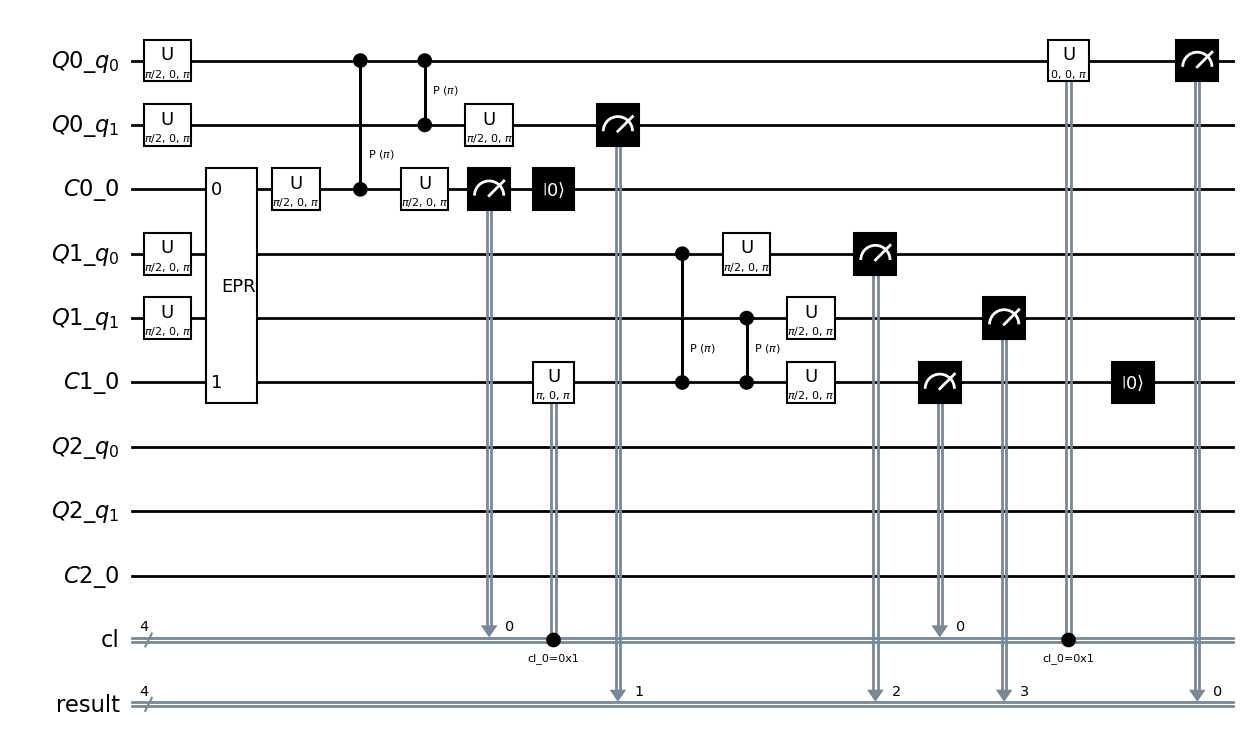

In [285]:
# Initialise a new extractor with the hypergraph and network

circuit_extractor = PartitionedCircuitExtractor(hypergraph, network, partition_assignment=partition_assignment)

partitioned_circuit = circuit_extractor.extract_partitioned_circuit()

print(f'Number of e-bits requested: {partitioned_circuit.count_ops()["EPR"]}')

partitioned_circuit.draw(output='mpl', style='bw', fold=50)

The circuit now uses just one e-bit. Note that the partitioned circuit is split into multiple registers. Each QPU has a data qubit register ```Qi``` and a communication qubit register ```Ci```, while a single classical register is used to store mid-circuit measurements. All qubits are measured at the end of the circuit, and permuted back into their logical order, since the assignment may have modified the original ordering. The final measurement result vector will be in the original logical order of the circuit. We can test the output of the circuit to ensure it still produces a GHZ state.

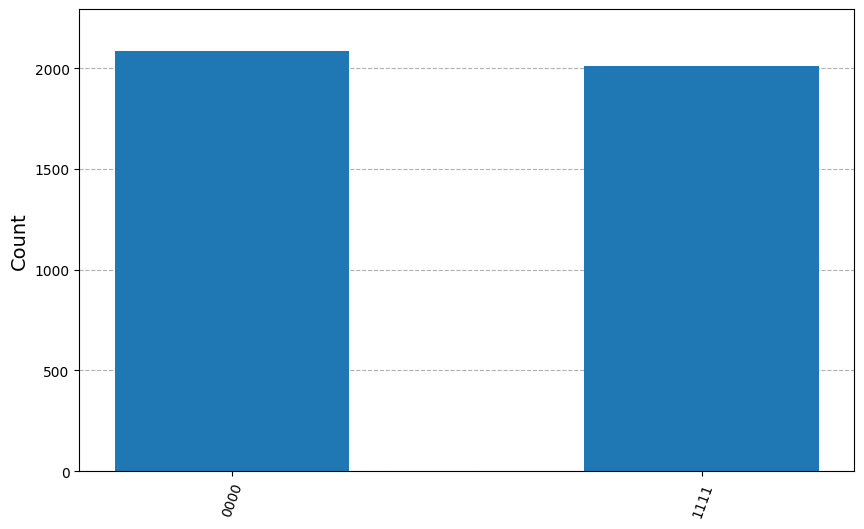

In [286]:
from disqco.circuit_extraction.verification import run_sampler, plot

# Run the sampler to verify the partitioned circuit
data = run_sampler(partitioned_circuit)

plot(data, labels=True)

We can see that, the output is indeed a GHZ state on the 4 input qubits. 

We now introduce the partitioning framework. The task of partitioning the temporal hypergraph reduces to finding a ```partition_assignment``` which minimises the number of e-bits required. As a partitioning backend, we use the Fiduccia-Mattheyses heuristic, coupled with both *temporal coarsening* and *network coarsening* techniques to enhance performance.

We implement the partitioning using the ```FiducciaMattheyses``` class, which is an instantiation of the general ```Partitioner``` class. We can pass the circuit straight into ```FiducciaMattheyses```, which will handle the graph creation. Since FM is a refinement heuristic, we may also specify an initial partition assignment, but this will be initialised inside the partitioner if not specified.

In [287]:
from disqco.parti.FM.fiduccia import FiducciaMattheyses

partitioner = FiducciaMattheyses(circuit, network, initial_assignment=partition_assignment)

We can use the basic ```partition``` method to produce an optimised partition_assignment.

Best cost: 1
depth: 5


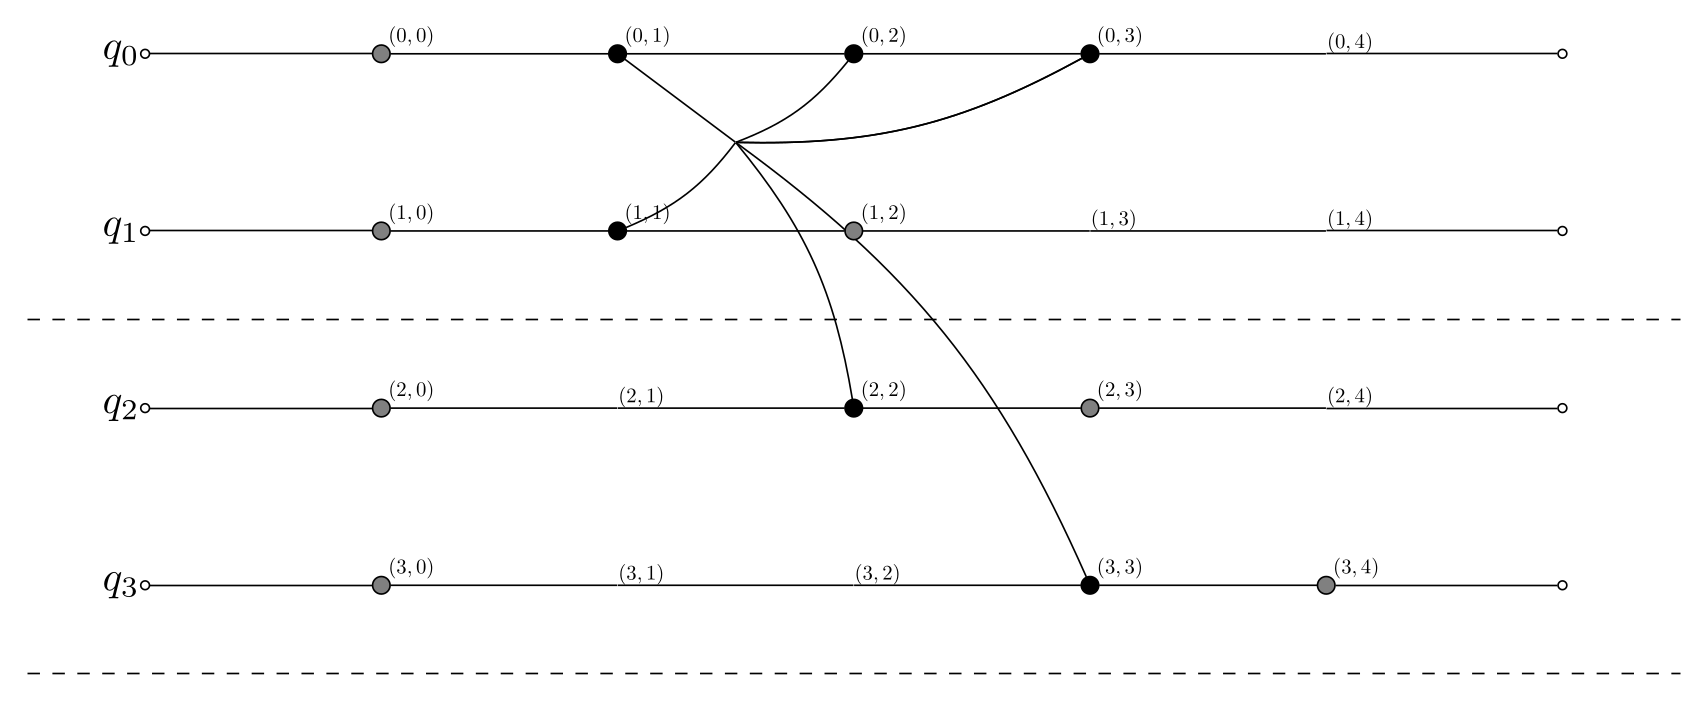

In [288]:
results = partitioner.partition(num_passes=10)

best_cost = results['best_cost']
best_assignment = results['best_assignment']

print(f'Best cost: {best_cost}')

hypergraph.draw(network=network, assignment=best_assignment, show_labels=True, dpi=300)

In this toy example, the initial assignment is the optimal, so we shouldn't see any change. However, we can try another, random circuit to see whether we can get an improvement.

This circuit now applied the GHZ creation sub-routine 4 times, each time shifting the initial qubit by one space.

In [289]:
from disqco.circuits.cp_fraction import cp_fraction
import numpy as np

num_qubits = 4


circuit = cp_fraction(num_qubits, 8*num_qubits, 0.3, seed=52345)


depth: 31


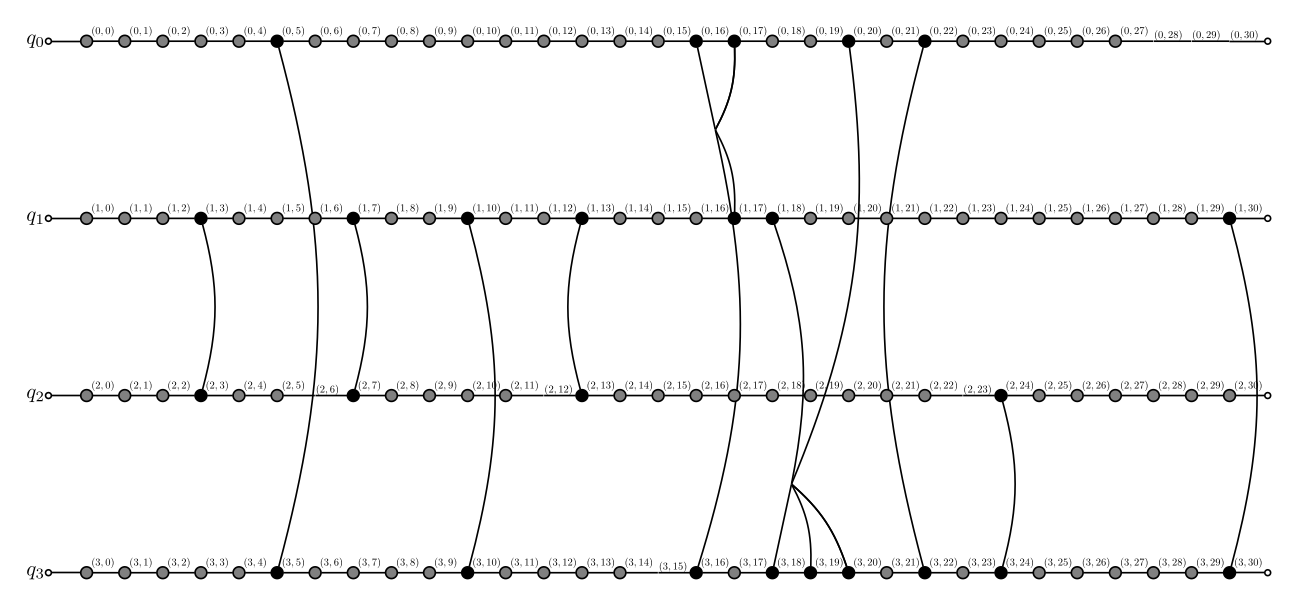

In [290]:

hypergraph = QuantumCircuitHyperGraph(circuit, group_gates=True)

hypergraph.draw(dpi=300)

Best cost: 5
depth: 31


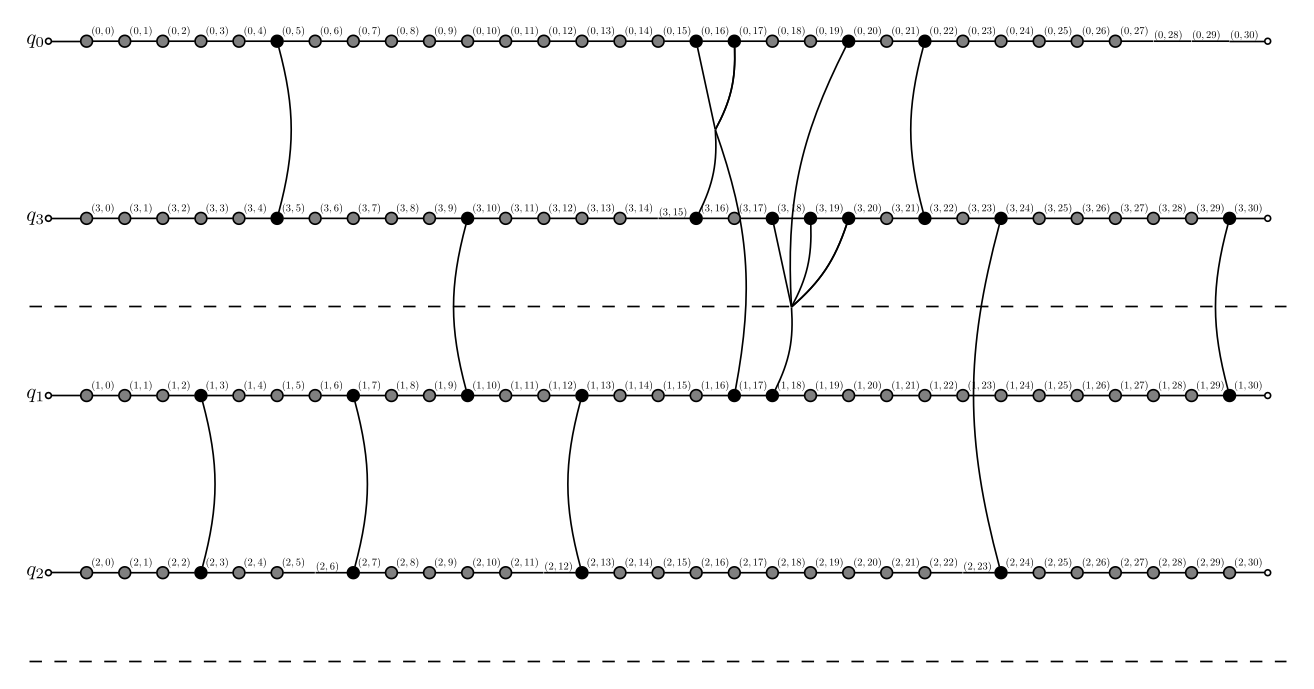

In [291]:
partition_assignment = set_initial_partition_assignment(hypergraph, network, round_robin=True)
partitioner = FiducciaMattheyses(circuit, network, initial_assignment=partition_assignment)
results = partitioner.partition(num_passes=50)

best_cost = results['best_cost']
best_assignment = results['best_assignment']

print(f'Best cost: {best_cost}')

hypergraph.draw(network=network, assignment=best_assignment, show_labels=True, dpi=300)

Number of e-bits requested: 5


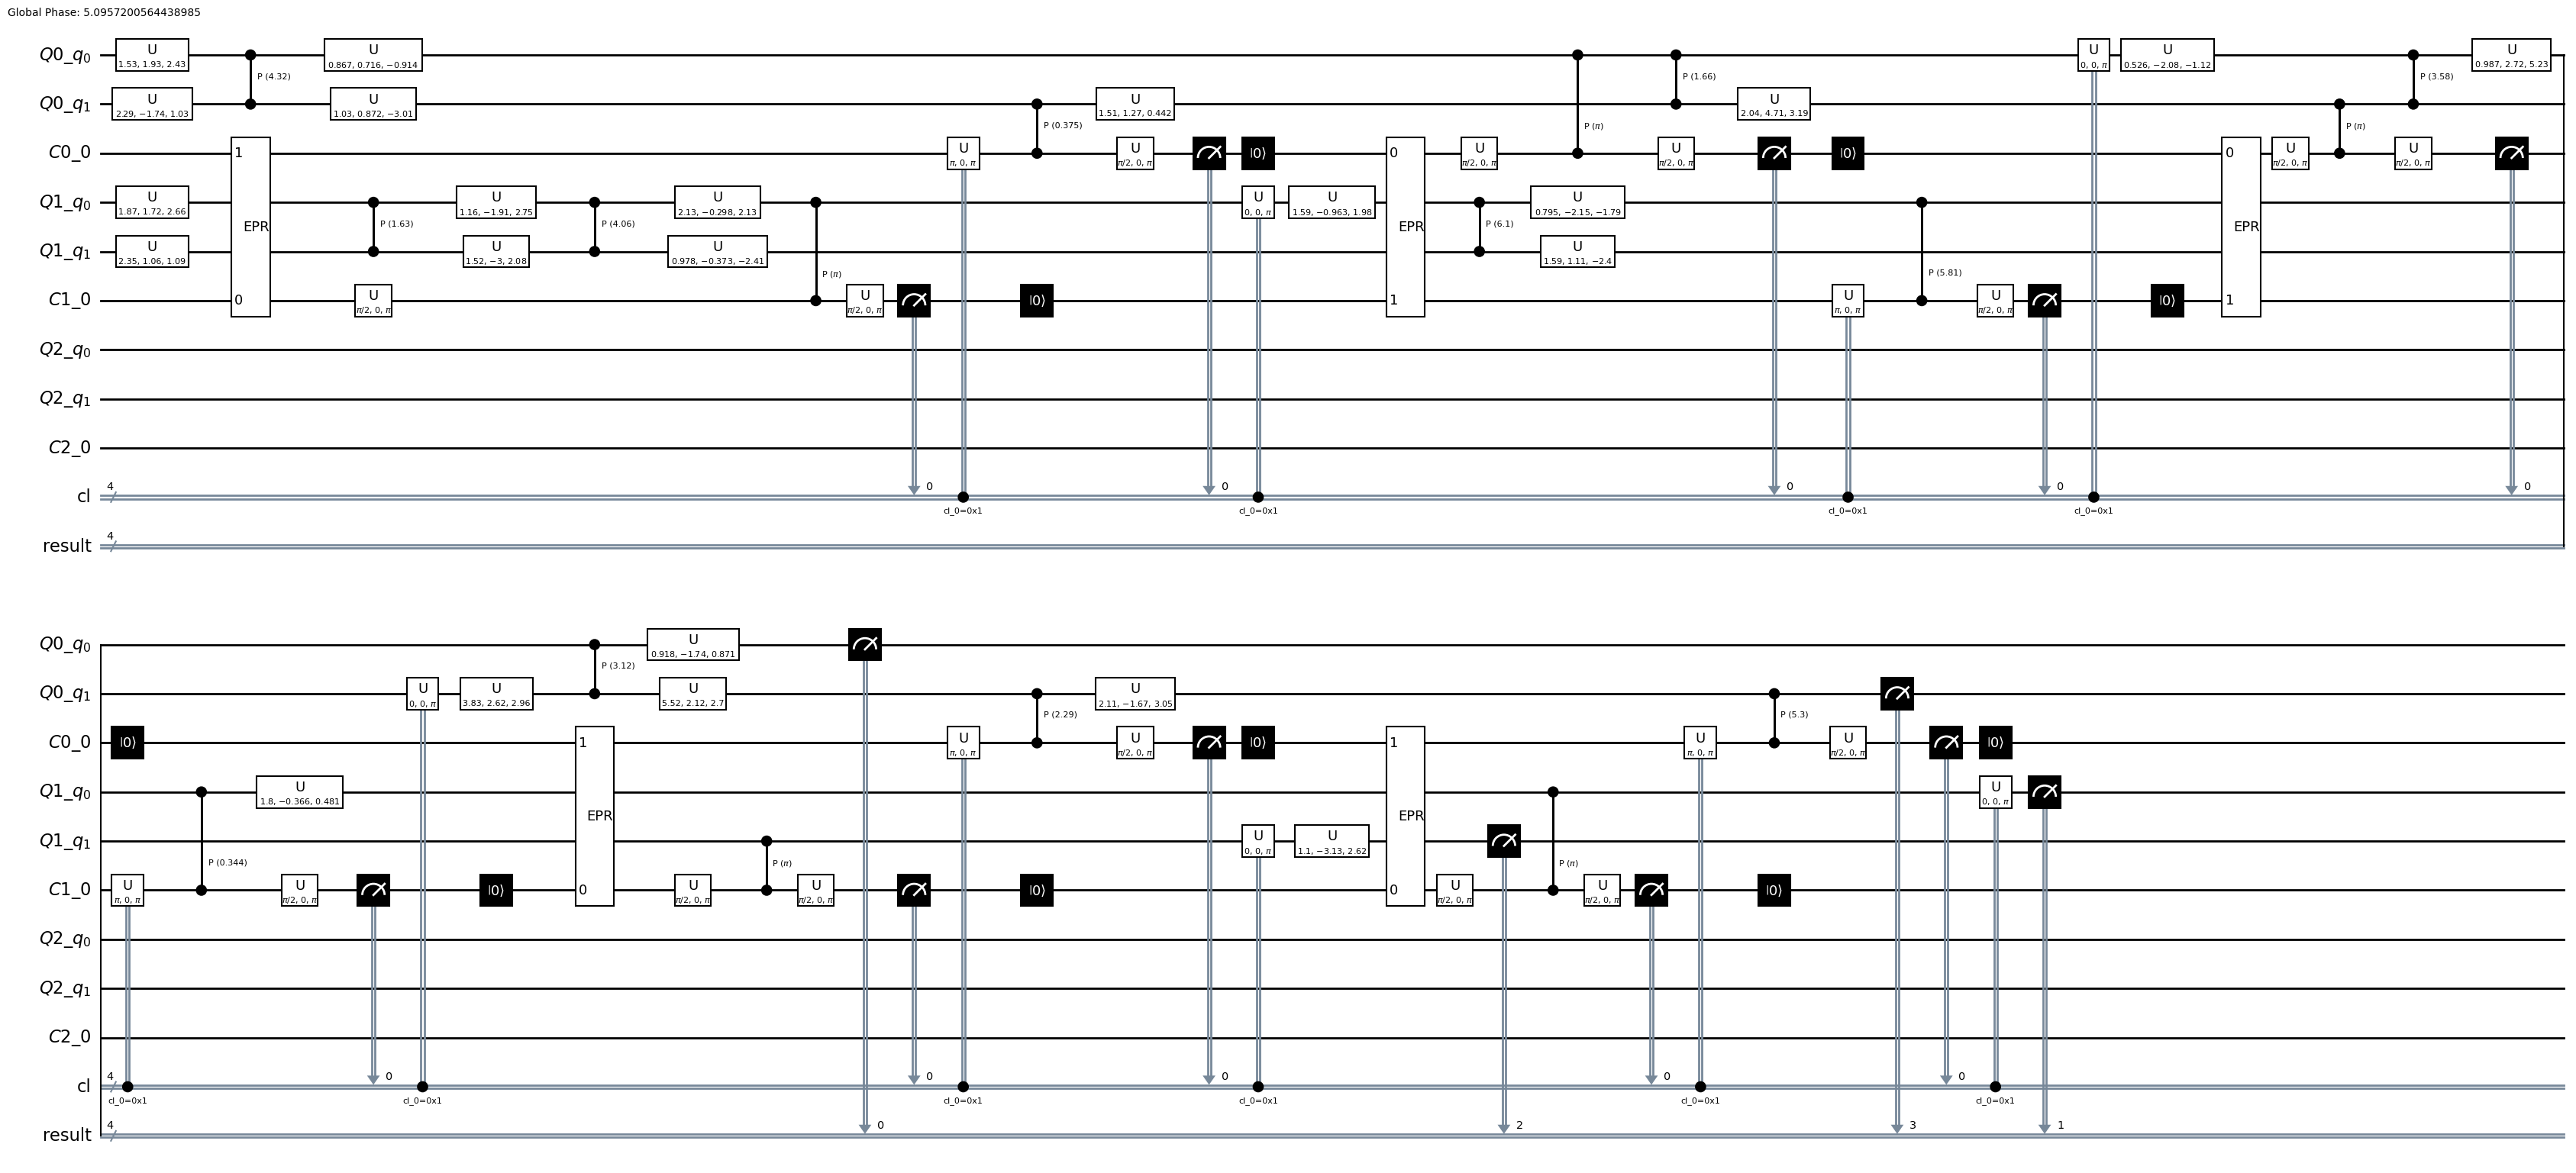

In [292]:
circuit_extractor = PartitionedCircuitExtractor(hypergraph, network, partition_assignment=best_assignment)

partitioned_circuit = circuit_extractor.extract_partitioned_circuit()

print(f'Number of e-bits requested: {partitioned_circuit.count_ops()["EPR"]}')
partitioned_circuit.draw(output='mpl', style='bw', fold=50)

Note that, in this case, we have passed in an all-to-all connected network. This means we do not have to request e-bits on any intermediate nodes, all QPUs are directly connected. This changes when we have other network toplogies which contain multi-hop paths between some QPUs. While we could always allow the network to handle multi-hop links, we can also optimise directly for the auxiliary entanglement required between the directly connected links. 

If we specify a network topology for our network, this will change the corresponding cost of the partition assignment, so the objective is different. Instances of the ```Partitioner``` class will account for this via the inputs ```QuantumNetwork```.

Let's create a linear network to test this.

Best cost: 7
depth: 31


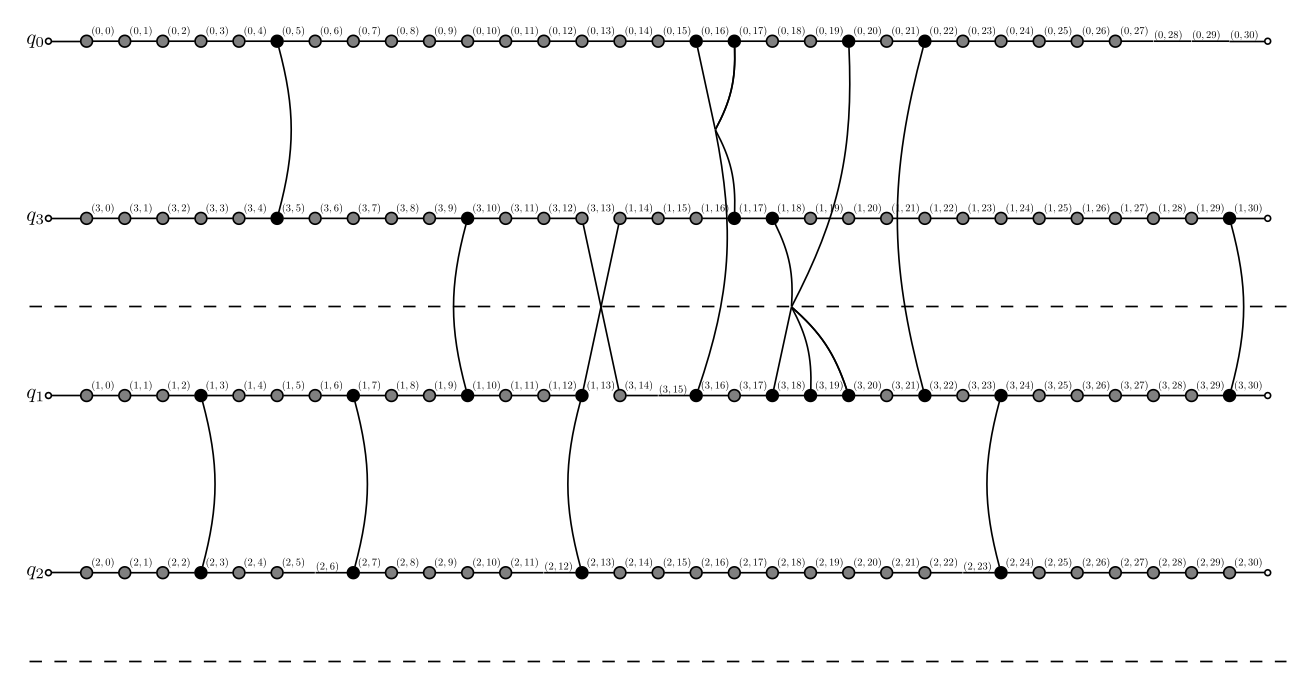

In [293]:

qpu_sizes = {0: 2, 1: 2, 2: 2}  # Three QPUs with 2 qubits each
num_qpus = len(qpu_sizes)

coupling = linear_coupling(N=num_qpus)  # Linear coupling for the network
network = QuantumNetwork(qpu_sizes, qpu_connectivity=coupling)

# Create a new partitioner class with the linear network, but the same circuit as before

partitioner = FiducciaMattheyses(circuit, network)
results = partitioner.partition(num_passes=50)

best_cost = results['best_cost']
best_assignment = results['best_assignment']

print(f'Best cost: {best_cost}')

hypergraph.draw(network=network, assignment=best_assignment, show_labels=True, dpi=300)

Non-local hyper-edges will now account for longer-range costs, so the optimisation will tend to avoid these connections. In most cases, the all-to-all network will lead to a lower cost than the linear network. However, it is possible that the optimisation finds a better solution with the linear network in place, since the partitioning is done heuristically.

When exporting a circuit, we can check that it is compatible with the constraints of the network.

Number of e-bits requested: 7


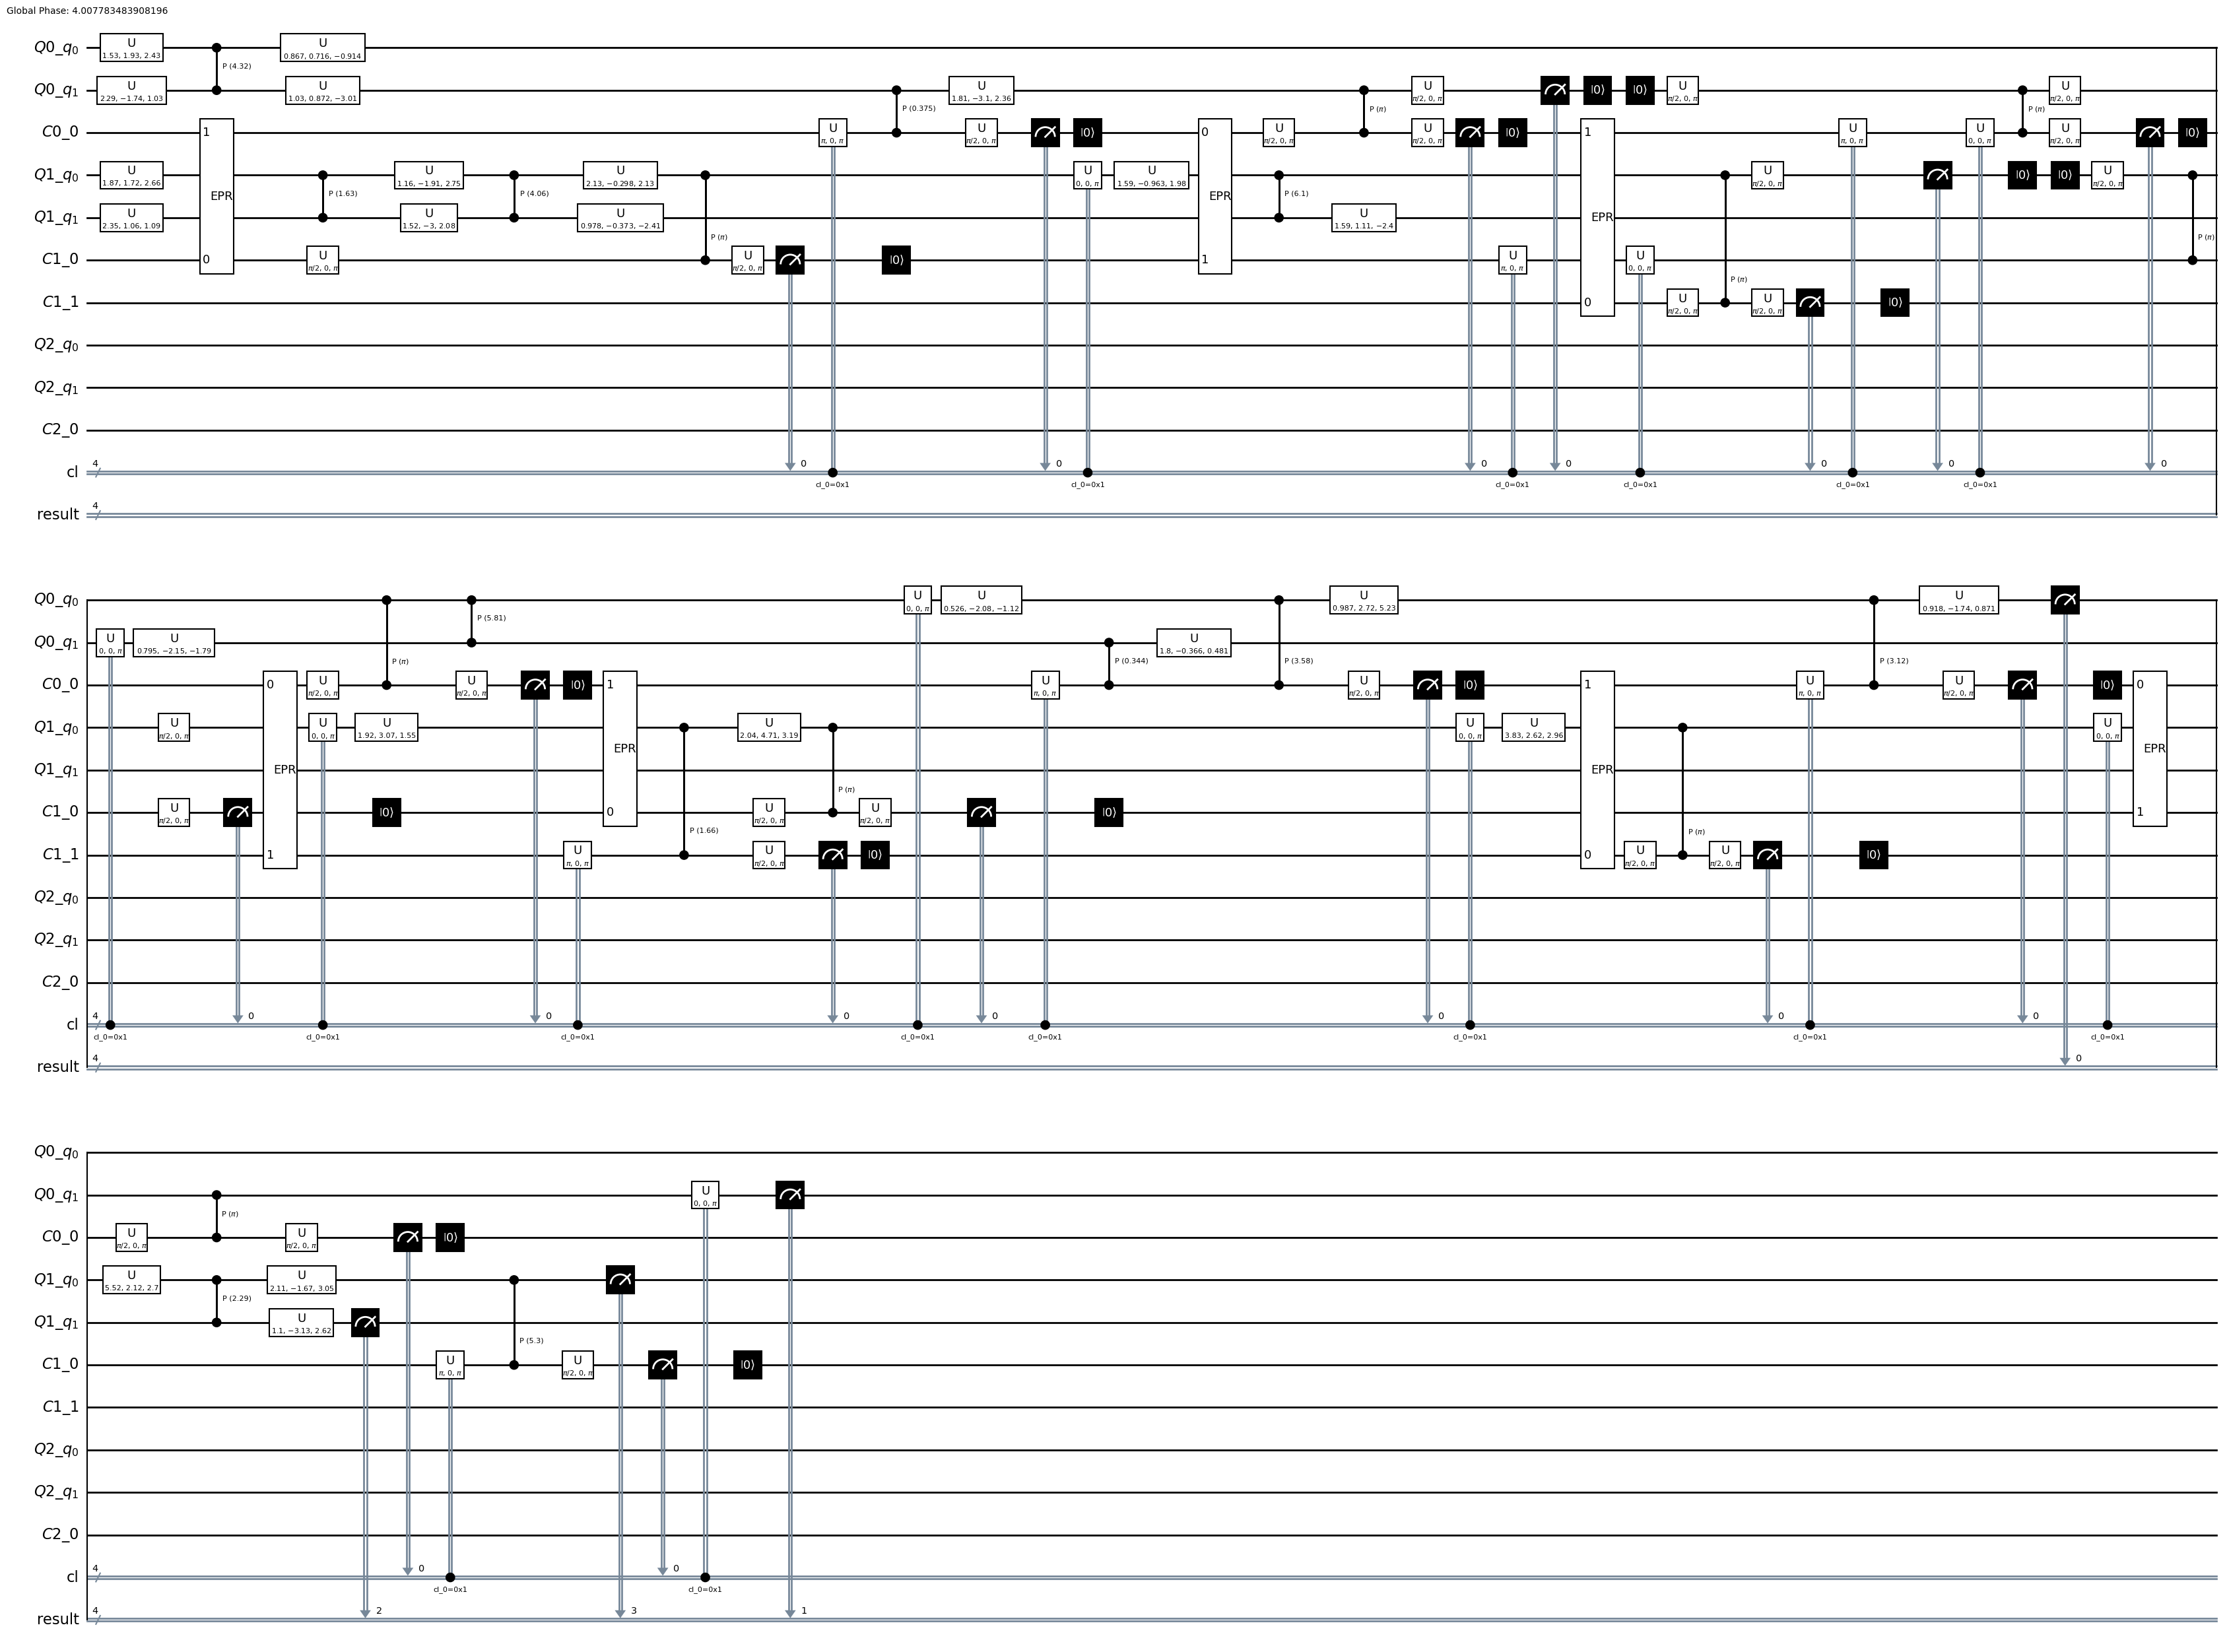

In [294]:
circuit_extractor = PartitionedCircuitExtractor(hypergraph, network, partition_assignment=best_assignment) 

partitioned_circuit = circuit_extractor.extract_partitioned_circuit()

print(f'Number of e-bits requested: {partitioned_circuit.count_ops()["EPR"]}')
partitioned_circuit.draw(output='mpl', style='bw', fold=50)

In [295]:
from disqco.circuit_extraction.verification import check_no_cross_partition_gates


if check_no_cross_partition_gates(partitioned_circuit, network.qpu_graph):
    print("No cross-partition gates found, circuit is valid for the given network graph")

No cross-partition gates found, circuit is valid for the given network graph
